This script solves the canonical Atkeson Burstein (2008) model. Emphasis has been placed on performance and scalability.

In [1]:
using LinearAlgebra, Plots, StatsPlots
using Random
using Base.Threads

using NonlinearSolve
using BenchmarkTools

In [2]:
Random.seed!(2023)

const num_threads = Threads.nthreads()
println("Number of threads: ", num_threads)

Number of threads: 6


In [3]:
# Define parameters
Base.@kwdef struct Params
    K::Int64 = 20 # firms per sector
    N::Int64 = 20_000 # number of sectors (n_firms = K*N)
    θ::Float64 = 0.385 # productivity distribution log z ~ N(0, theta); could be sector specific
    η::Float64 = 1.01 # across sector demand elasticity
    ρ::Float64 = 10.0 # within sector demand elasticity
end

Params

In [4]:
function compute_markup(share, par::Params)
    # Update elasticity of demand for the Cournot competition case.
    e_inv = share / par.η + (1. - share) / par.ρ

    # Update markups
    return 1. / (1. - e_inv)
end

compute_markup (generic function with 1 method)

In [5]:
# === Inner loop: compute equilibrium for given industry === #
function _solve_industry!(F, shares, p)
    par = p.par
    for row in eachindex(F)
        # Update markup
        markup = compute_markup(shares[row], par)

        # Update market share
        F[row] = (p.z[row] / markup) ^ (par.ρ - 1.)
    end

    F ./= sum(F)
    F .-= shares 

    nothing
end

# === Outer loop: compute equilibrium over all industries === #
function solve_industries!(shares, z, par, nlcaches, fu)
    Threads.@threads for col in axes(shares, 2)
        id_ = Threads.threadid()
        @views p = (par = par, z = z[:, col])

        reinit!(nlcaches[id_]; p = p)
        NonlinearSolve.solve!(nlcaches[id_])

        fu_ = @view(fu[:, id_])
        _solve_industry!(fu_, nlcaches[id_].u, p)
        @assert norm(fu_, Inf) < sqrt(eps()) "Failed to solve for market shares: $(fu_))"

        @. shares[:, col] = nlcaches[id_].u
    end

    nothing
end

# === Compute HHI index for given industry === #
function compute_HHI(shares, par::Params)
    HHI = zero(eltype(shares))
    for row in 1:par.K
        HHI += shares[row] ^ 2
    end 

    return HHI * 100.
end

compute_HHI (generic function with 1 method)

In [6]:
# === Compute equilibrium for all industries in parallel === #
function solve_AK(; num_threads=num_threads)
    # === Set up the problem === #
    par = Params(); #Params(; N=180, K=1600 ÷ 180)
    z = exp.(randn(par.K, par.N) * par.θ);
    sort!(z, dims=1)
    s_init = ones(par.K) / par.K

    # Initialise the nonlinear solver
    @views p = (par = par, z = z[:, 1])

    # Initialise the problem
    probs = [NonlinearProblem(_solve_industry!, copy(s_init), p) for _ in 1:num_threads]
    nlcaches = [init(prob, TrustRegion()) for prob in probs]
    fu = ones(par.K, num_threads) * 100. # Tracking the residual

    # Initalise the solution
    shares = zeros(par.K, par.N)

    # Solve for the equilibrium shares
    solve_industries!(shares, z, par, nlcaches, fu)
    # @time solve_industries!(shares, z, par, nlcache, fu)

    # Back out the implied markups
    markups = compute_markup.(shares, Ref(par))

    # Compute HHI
    HHI = reshape(sum(shares .^ 2, dims=1) * 100., par.N)

    return shares, markups, HHI, z, par
end

solve_AK (generic function with 1 method)

In [7]:
# === Time the solution === #
@benchmark solve_AK()

BenchmarkTools.Trial: 22 samples with 1 evaluation.
 Range (min … max):  206.131 ms … 253.505 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     240.329 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   238.381 ms ±  11.037 ms  ┊ GC (mean ± σ):  0.45% ± 0.94%

                                      ▃        ▃    █         ▃  
  ▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▁▇▁▁▁▁▁▁▁▇▁▇▁▇█▁▁▇▁▁▇▇▇█▁▁▁▇█▁▇▁▁▁▁▁▇▁█ ▁
  206 ms           Histogram: frequency by time          254 ms <

 Memory estimate: 24.92 MiB, allocs estimate: 41911.

In [13]:
# === Final run retrieving the solution === #
shares, markups, HHI, z, par = solve_AK();

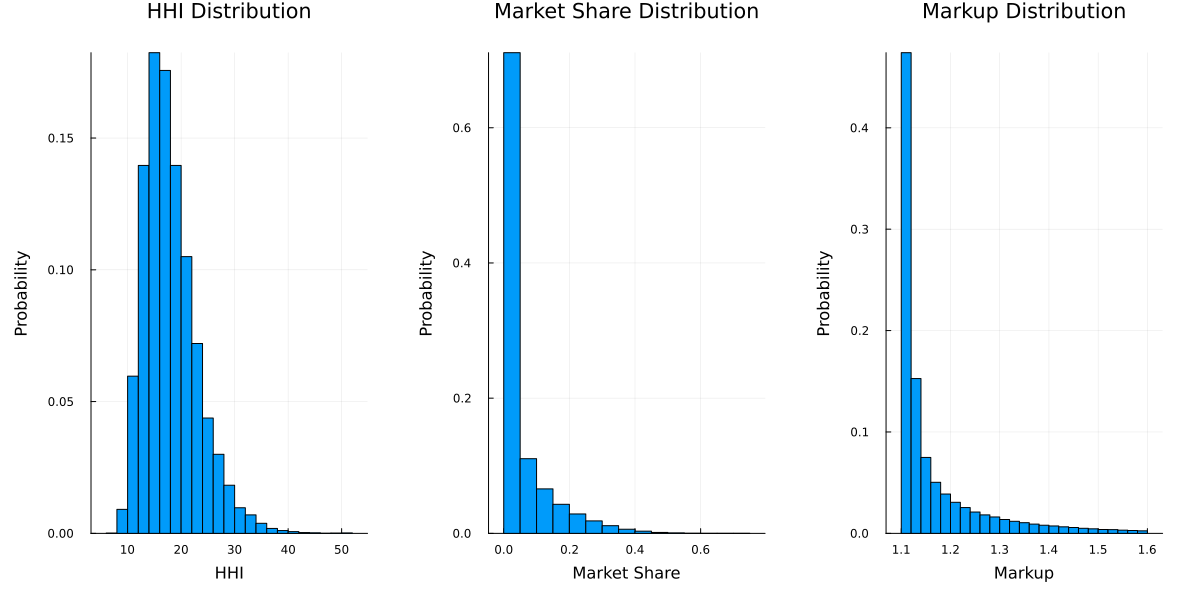

In [9]:
# ================================
# ===       Plotting         === #
# ================================

# === Histograms of distribution within sector === #
p1 = histogram(HHI, bins=30, normalize=:probability, legend=false, xlabel="HHI", ylabel="Probability")
p2 = histogram(shares[:], bins=25, normalize=:probability, legend=false, xlabel="Market Share", ylabel="Probability")
p3 = histogram(markups[markups .<= 1.6][:], bins=25, normalize=:probability, legend=false, xlabel="Markup", ylabel="Probability")

plot(p1, p2, p3, layout=(1,3), size=(1200,600), 
     title=["HHI Distribution" "Market Share Distribution" "Markup Distribution"],
     margins = 0.75Plots.cm)

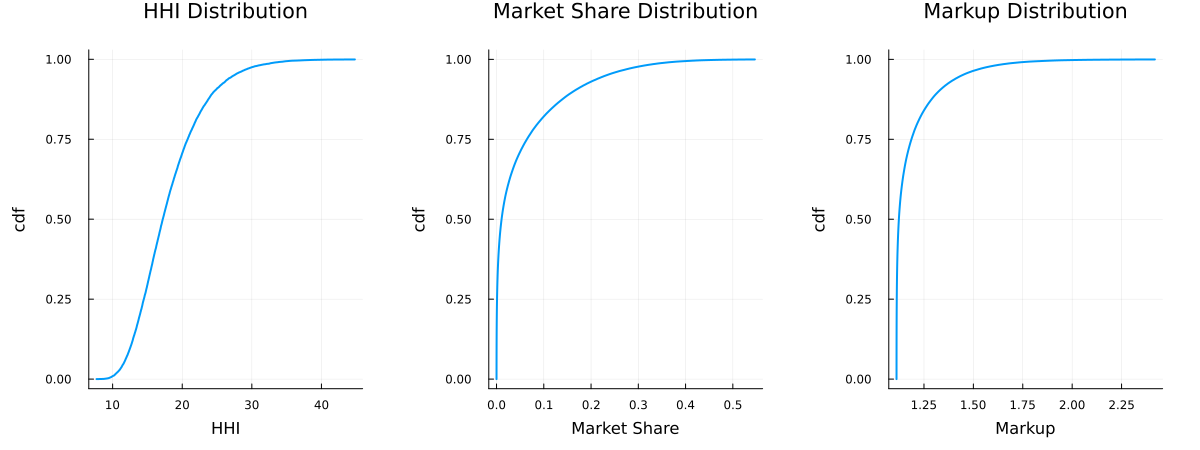

In [10]:
# === Plotting CDFs === #
using StatsBase
hhi_sorted = sort(HHI)
shares_sorted = sort(shares[:])
markups_sorted = sort(markups[:])

hhi_cdf = ecdf(hhi_sorted)
shares_cdf = ecdf(shares_sorted)
markups_cdf = ecdf(markups_sorted)

p1 = plot(hhi_sorted[1:10:end], hhi_cdf.(hhi_sorted[1:10:end]), linewidth=2, xlabel="HHI", ylabel="cdf")
p2 = plot(shares_sorted[1:100:end], shares_cdf.(shares_sorted[1:100:end]), linewidth=2, xlabel="Market Share", ylabel="cdf")
p3 = plot(markups_sorted[1:100:end], markups_cdf.(markups_sorted[1:100:end]), linewidth=2, xlabel="Markup", ylabel="cdf")

plot(p1, p2, p3, layout=(1,3), size=(1200,450), 
    title=["HHI Distribution" "Market Share Distribution" "Markup Distribution"], legend=false,
    margins = 0.75Plots.cm)

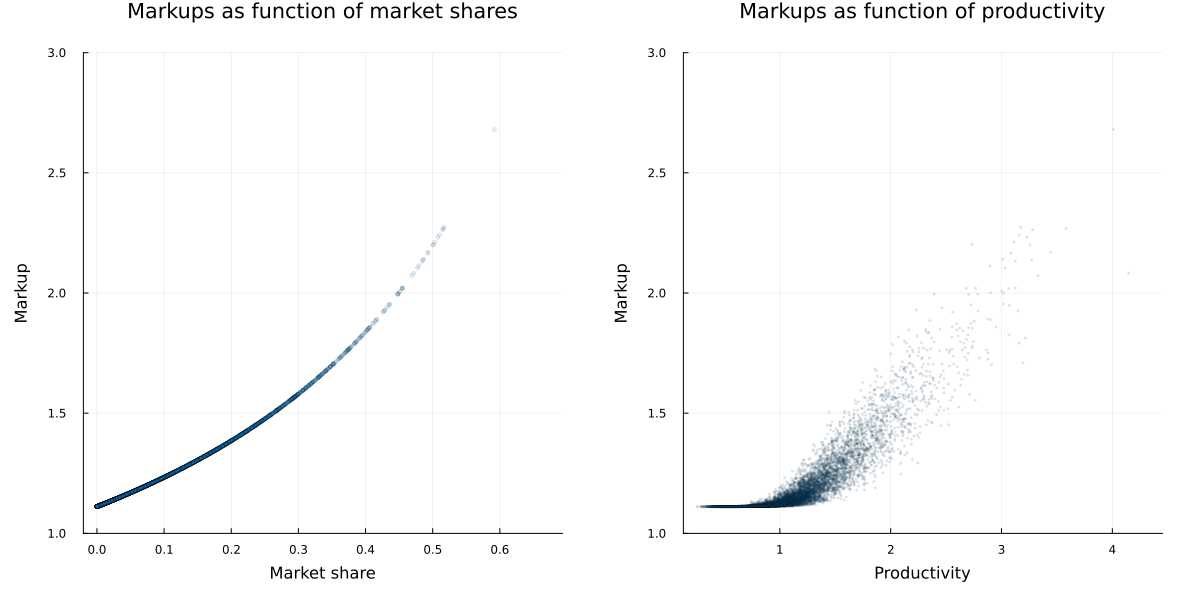

In [15]:
# === Scatterplot of market shares and markups === #
indices = randperm(par.K * par.N)[1:10_000]

p1 = scatter(shares[indices], markups[indices], markersize=2, markeralpha=0.1, ylims=(1,3),
             xlabel="Market share", ylabel="Markup", title="Markups as function of market shares",
             label=false)
p2 = scatter(z[indices], markups[indices], markersize=1, markeralpha=0.1, ylims=(1,3), 
             xlabel="Productivity", ylabel="Markup", title="Markups as function of productivity", 
             label=false)

plot(p1, p2, layout=(1,2), size=(1200,600), margins = 0.75Plots.cm)